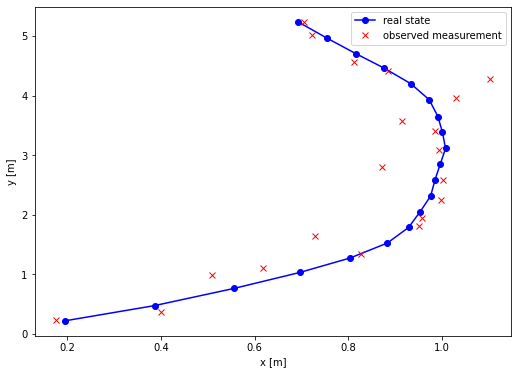

In [2]:
import numpy as np
import matplotlib.pyplot as plt


class MotionModel():
    def __init__(self, A, B, Q):
        self.A = A # Motion evolution matrix - gives next real state from previous real state
        self.B = B # Motion control matrix - gives change in real state resulting from control vector u
        self.Q = Q # Motion covariance matrix

        (m, _) = Q.shape
        self.zero_mean = np.zeros(m)

    def __call__(self, x, u):
        next_state = self.A @ x + self.B @ u + np.random.multivariate_normal(self.zero_mean, self.Q)
        return next_state


class MeasurementModel():
    def __init__(self, H, R):
        self.H = H # Measurement matrix - gives measured state from real state
        self.R = R # Measurement covariance matrix

        (n, _) = R.shape
        self.zero_mean = np.zeros(n)

    def __call__(self, x):
        measurement = self.H @ x + np.random.multivariate_normal(self.zero_mean, self.R)
        return measurement


def create_model_parameters(T=1, s2_x=0.02 ** 2, s2_y=0.02 ** 2, lambda2=0.08 ** 2, mass=1):
    """
    T       : sample period (seconds)
    s2_x    : x motion variance - scaling factor for motion uncertainty
    s2_y    : y motion variance - scaling factor for motion uncertainty
    lambda2 : measurement variance = scaling factor for measurement uncertainty
    mass    : mass of robot (kg)
    """
    # Motion model parameters
    F = np.array([[1, T],
                  [0, 1]])
    G = np.array([[1, 0],
                  [0, T/mass]])
    base_sigma = np.array([[T ** 3 / 3, T ** 2 / 2],
                           [T ** 2 / 2, T]])

    sigma_x = s2_x * base_sigma
    sigma_y = s2_y * base_sigma

    zeros_2 = np.zeros((2, 2))
    A = np.block([[F, zeros_2],
                  [zeros_2, F]])
    B = np.block([[G, zeros_2],
                  [zeros_2, G]])
    Q = np.block([[sigma_x, zeros_2],
                  [zeros_2, sigma_y]])

    # Measurement model parameters
    H = np.array([[1, 0, 0, 0],
                  [0, 0, 1, 0]])
    R = lambda2 * np.eye(2)

    return A, B, H, Q, R


def simulate_system(K, x0, u):
    """
    K   : the number of points (updates) to simulate
    x0  : the initial state vector
    u   : control matrix, where each row is a control vector (must be K-by-4)
          the control vector is (dx, x_F, dy, y_F)
    """
    (A, B, H, Q, R) = create_model_parameters()

    # Create models
    motion_model = MotionModel(A, B, Q)
    meas_model = MeasurementModel(H, R)

    (m, _) = Q.shape
    (n, _) = R.shape

    state = np.zeros((K, m))
    meas = np.zeros((K, n))

    # initial state
    x = x0
    for k in range(K):
        x = motion_model(x, u[k])
        z = meas_model(x)

        state[k, :] = x
        meas[k, :] = z

    return state, meas


"""
Simulation:
seed random number generator, run K updates from the following initial state:
start at origin with x_vel = 0.1 m/s, y_vel = 0.1 m/s
"""
np.random.seed(26)

# initial state
K = 20
x0 = np.array([0, 0.2, 0, 0.2])
u = np.zeros((K,4))
u[:,1] = -0.01
#u[1:10,2] = 0.5
#u[11:20,0] = 0.5
(state, meas) = simulate_system(K, x0, u)

plt.figure(figsize=(7, 5))
plt.plot(state[:, 0], state[:, 2], '-bo')
plt.plot(meas[:, 0], meas[:, 1], 'rx')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(['real state', 'observed measurement'])
plt.tight_layout(pad=0)
plt.show()

**Step 1) Simulate motion and measurement models**

the state vector has 4 elements:
(x_pos, x_vel, y_pos, y_vel)

Motion is modeled with a motion matrix, and a variance factor s^2

Measurement is modeled with a measurement matrix, and a variance factor lambda^2

**Step 2) Produce estimate of state with Kalman filter**

Since we've assumed all distributions are gaussian, we can use a Kalman filter to estimate state

[]

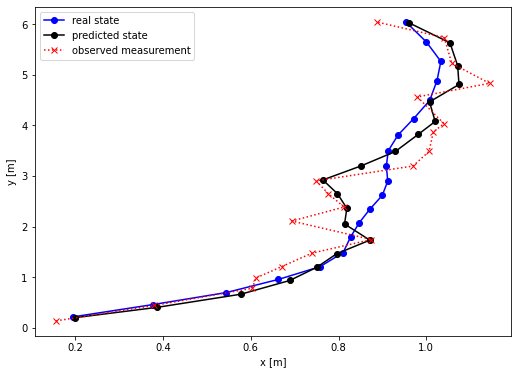

In [3]:
class KalmanFilter():
    def __init__(self, A, B, H, Q, R, x_0, u_0, P_0):
        """
        A, H, Q, R  : the model and variance matrices as described in MotionModel and MeasurementModel
        x_0         : the initial real state vector (x, x_v, y, y_v)
        u_0         : the initial control vector (dx, x_F, dy, y_F)
        P_0         : the initial predicted state vector (prior)
        """
        # Model parameters
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R

        # Initial state
        self._x = x_0
        self._u = u_0
        self._P = P_0

    def predict(self):
        self._x = self.A @ self._x + self.B @ self._u
        self._P = self.A @ self._P @ self.A.transpose() + self.Q

    def update(self, z, u_k):
        self.S = self.H @ self._P @ self.H.transpose() + self.R
        self.V = z - self.H @ self._x
        self.K = self._P @ self.H.transpose() @ np.linalg.inv(self.S)

        self._x = self._x + self.K @ self.V
        self._P = self._P - self.K @ self.S @ self.K.transpose()
        self._u = u_k

    def get_state(self):
        return self._x, self._P

"""
Simulation:
model the motion and measurement of the state for K steps, as  before

"""
np.random.seed(22)
(A, B, H, Q, R) = create_model_parameters()

prior = 0 * np.eye(4)
(state, meas) = simulate_system(K, x0, u)
kalman_filter = KalmanFilter(A, B, H, Q, R, x0, u[0], prior)

est_state = np.zeros((K, 4))
est_cov = np.zeros((K, 4, 4))

for k in range(K):
    kalman_filter.predict()
    if k+1 == len(u):
      kalman_filter.update(meas[k, :], u[0])
    else:
      kalman_filter.update(meas[k, :], u[k+1])
    (x, P) = kalman_filter.get_state()

    est_state[k, :] = x
    est_cov[k, ...] = P

plt.figure(figsize=(7, 5))
plt.plot(state[:, 0], state[:, 2], '-bo')
plt.plot(est_state[:, 0], est_state[:, 2], '-ko')
plt.plot(meas[:, 0], meas[:, 1], ':rx')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(['real state', 'predicted state', 'observed measurement'])
plt.tight_layout(pad=0)
plt.plot()
